# Visualización de Detecciones DAS (Raw, Procesado y Energía)
Este notebook muestra el dato original (Viridis), la señal preprocesada (RdBu) y el mapa de energía (Magma) con los rectángulos de detección marcados en los datos de señal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import joblib
import pandas as pd
import yaml
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from preprocessing.das_preprocess import read_das_npz, downsample_das, preprocess_das_timespace

DATA_DIR = PROJECT_ROOT / "data"
DETECTIONS_DIR = PROJECT_ROOT / "outputs"
CONFIG_PATH = PROJECT_ROOT / "config.yaml"

with open(CONFIG_PATH, "r") as f:
    cfg = yaml.safe_load(f)


ARCHIVO: becario_20252623_092624UTC_tfin_20252623_092624UTC


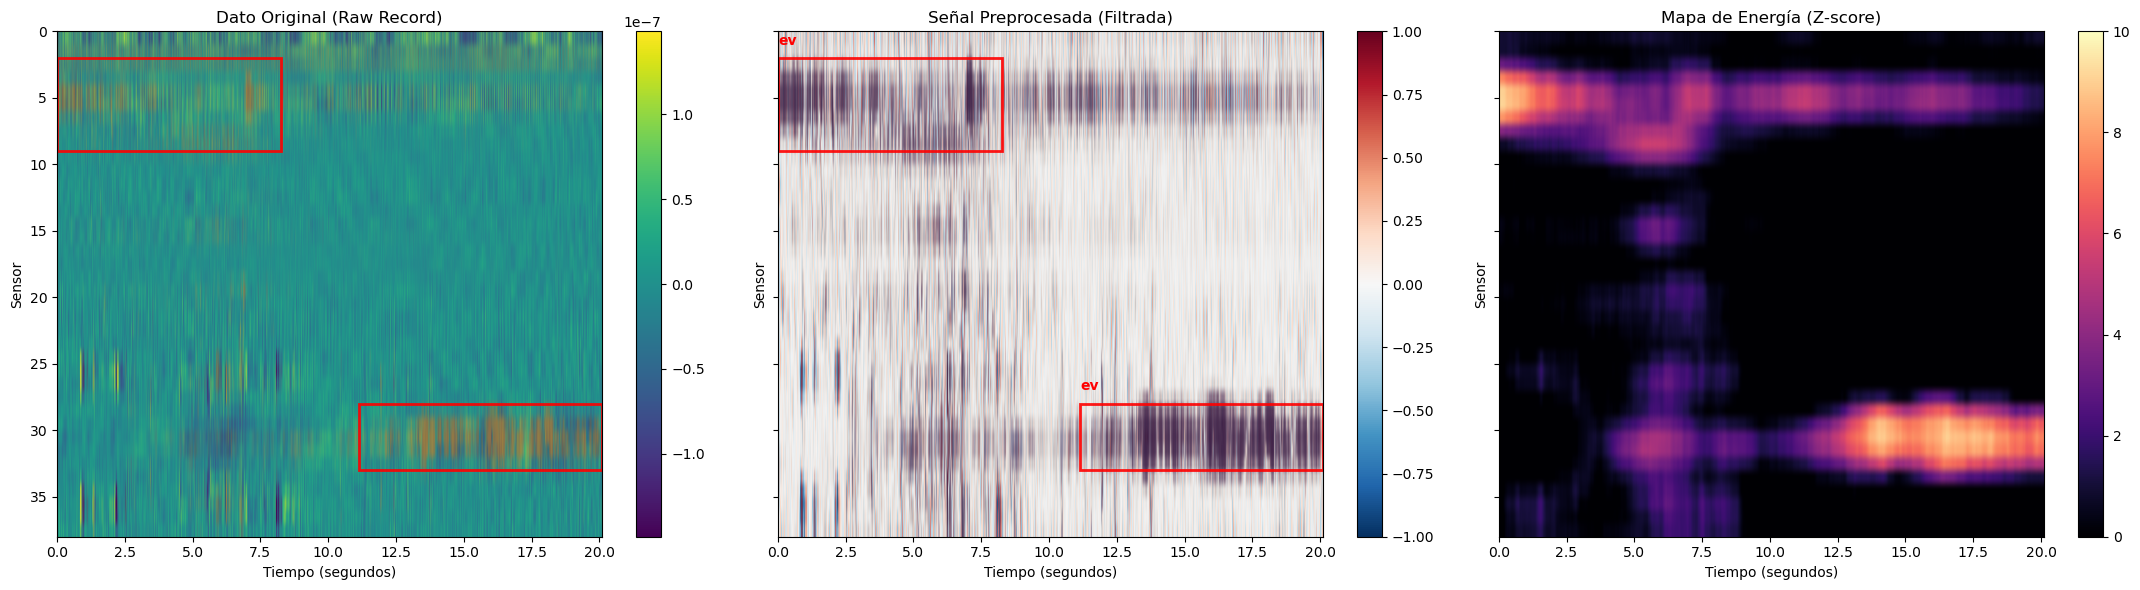

,t_start,t_end,t_start_idx,t_end_idx,sensor_start,sensor_end,sensor_center,duration_sec,n_sensors,mean_energy,max_energy,file
0,0.000000,8.259127,0,8373,2,9,5,8.260114,8,4.712655,9.147942,becario_20252623_092624UTC_tfin_20252623_09262...
1,11.139415,20.099873,11293,20377,28,33,30,8.961444,6,6.314167,9.065682,becario_20252623_092624UTC_tfin_20252623_09262...



ARCHIVO: becario_20252623_092649UTC_tfin_20252723_092649UTC


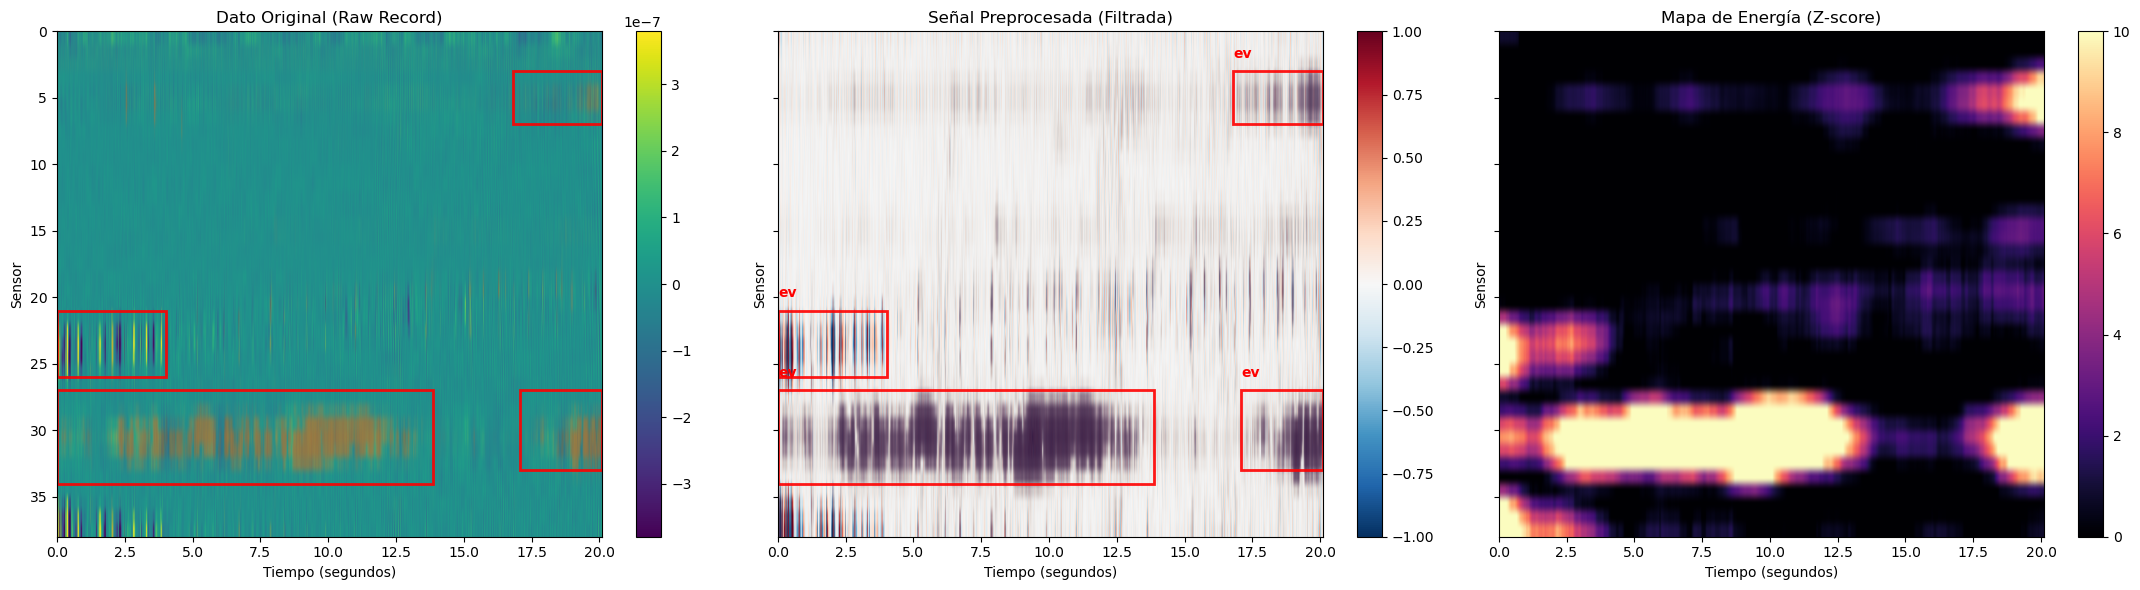

,t_start,t_end,t_start_idx,t_end_idx,sensor_start,sensor_end,sensor_center,duration_sec,n_sensors,mean_energy,max_energy,file
0,0.000000,4.014648,0,4070,21,26,23,4.015634,6,5.993508,13.616897,becario_20252623_092649UTC_tfin_20252723_09264...
1,0.000000,13.864838,0,14056,27,34,30,13.865825,8,11.570403,20.612306,becario_20252623_092649UTC_tfin_20252723_09264...
2,16.801351,20.099873,17033,20377,3,7,5,3.299508,5,6.726393,14.069037,becario_20252623_092649UTC_tfin_20252723_09264...
3,17.092339,20.099873,17328,20377,27,33,30,3.008520,7,10.199136,19.119360,becario_20252623_092649UTC_tfin_20252723_09264...


In [4]:
subdirs = [d for d in DETECTIONS_DIR.iterdir() if d.is_dir()]

if not subdirs:
    print("No se encontraron subcarpetas en 'outputs/'.")
else:
    for target_dir in subdirs:
        print(f"\n{'='*60}\nARCHIVO: {target_dir.name}\n{'='*60}")
        
        try:
            # 1. Cargar dato original (.npz)
            npz_path = DATA_DIR / f"{target_dir.name}.npz"
            das_data = read_das_npz(npz_path)
            
            # 2. Preprocesado al vuelo (usando config actual)
            das_ds = downsample_das(das_data, cfg["signal"]["target_fs"])
            fs = das_ds["sampling_freq"]
            X_raw = das_ds["strain_data"]
            
            X_proc = preprocess_das_timespace(
                X_raw, fs=fs, 
                fmin=cfg["signal"]["fmin"], 
                fmax=cfg["signal"]["fmax"], 
                sigma_2d=cfg["signal"]["sigma_2d"]
            )
            
            # 3. Cargar resultados y eventos
            E = np.load(target_dir / "energy.npy")
            events = joblib.load(target_dir / "events.pkl")
            
            t_axis = np.arange(X_proc.shape[0]) / fs
            extent = [t_axis[0], t_axis[-1], X_proc.shape[1], 0]

            fig, ax = plt.subplots(1, 3, figsize=(22, 6), sharex=True, sharey=True)
            
            # A. DATO ORIGINAL (PALETA VIRIDIS) CON RECTÁNGULOS
            vlim_raw = np.percentile(np.abs(X_raw), 98)
            im0 = ax[0].imshow(X_raw.T, aspect='auto', cmap='viridis', 
                               extent=extent, vmin=-vlim_raw, vmax=vlim_raw)
            ax[0].set_title("Dato Original (Raw Record)")
            plt.colorbar(im0, ax=ax[0])
            
            for ev in events:
                rect = patches.Rectangle((ev['t_start'], ev['sensor_start']), 
                                         ev['t_end']-ev['t_start'], ev['sensor_end']-ev['sensor_start'], 
                                         linewidth=2, edgecolor='red', facecolor='none', alpha=0.9)
                ax[0].add_patch(rect)

            # B. SEÑAL PREPROCESADA (PALETA RDBU_R) CON RECTÁNGULOS
            im1 = ax[1].imshow(X_proc.T, aspect='auto', cmap='RdBu_r', 
                               extent=extent, vmin=-1, vmax=1)
            ax[1].set_title("Señal Preprocesada (Filtrada)")
            plt.colorbar(im1, ax=ax[1])
            
            for ev in events:
                rect = patches.Rectangle((ev['t_start'], ev['sensor_start']), 
                                         ev['t_end']-ev['t_start'], ev['sensor_end']-ev['sensor_start'], 
                                         linewidth=2, edgecolor='red', facecolor='none', alpha=0.9)
                ax[1].add_patch(rect)
                ax[1].text(ev['t_start'], ev['sensor_start']-1, f"ev", color='red', fontsize=10, weight='bold')

            # C. MAPA DE ENERGÍA (PALETA MAGMA)
            im2 = ax[2].imshow(E.T, aspect='auto', cmap='magma', extent=extent, vmin=0, vmax=10)
            ax[2].set_title("Mapa de Energía (Z-score)")
            plt.colorbar(im2, ax=ax[2])
            
            for a in ax:
                a.set_xlabel("Tiempo (segundos)")
                a.set_ylabel("Sensor")

            plt.tight_layout()
            plt.show()
            
            if len(events) > 0:
                display(pd.DataFrame(events))
                
        except Exception as e:
            print(f"Error al procesar {target_dir.name}: {e}")
            continue
